In [309]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import yfinance as yf
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression






In [310]:
from pathlib import Path
import pandas as pd


user = 'omarlodhi'

figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_3/figures'


# preprocessing data


# Define the path to the directory containing the CSV files
investing_data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_3/data/investing.com')
FRED_data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_3/data/FRED')




dataframes = {}

for csv_file in investing_data_path.glob("*.csv"):
    file_name = csv_file.stem
    df = pd.read_csv(csv_file)

    if 'Date' in df.columns and 'Price' in df.columns:
        df = df[['Date', 'Price']]
        df.rename(columns={'Price': file_name}, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values(by='Date', ascending=False, inplace=True)

        dataframes[file_name] = df  # Store in dictionary instead of globals()

# Ensure 'observation_date' exists before renaming

# Iterate over each CSV file in the directory
for csv_file in FRED_data_path.glob("*.csv"):
    file_name = csv_file.stem  # Get the file name without the extension
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    if 'observation_date' in df.columns:
        df.rename(columns={'observation_date': 'Date'}, inplace=True)
        
        # Rename all other columns to match the file name
        for col in df.columns:
            if col != 'Date':  # Keep 'Date' as is
                df.rename(columns={col: file_name}, inplace=True)
        
        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Sort by date in ascending order
        df.sort_values(by='Date', ascending=False, inplace=True)
        
        # Store DataFrame in dictionary
        dataframes[file_name] = df



df_total = pd.DataFrame()

for df in dataframes.values():
    if df_total.empty:
        df_total = df
    else:
        df_total = pd.merge(df_total, df, on='Date', how='inner')

print(df_total.columns)

df_total['spy'] = df_total['spy'].replace({',': ''}, regex=True).astype(float)

df_total['prop'] = (df_total['size'] / (1000000)) / 27

df_total['curve'] = (df_total['10yr_yield'] - df_total['2yr_yield']) * 100

Index(['Date', 'spy', 'move_index', '5yr_yield', '3yr_swap_rate',
       '3m_treasury_ffr_spread', '6_treasury_ffr_spread', '5y_BE',
       'corporate_a_ffr_spread', '30yr_swap_rate', '4yr_swap_rate',
       'corporate_ffr_spread', '3yr_yield', '30yr_yield', 'corporate_spread',
       '5yr_swap_rate', '5r_swap_rate', '2yr_swap_rate',
       '5yr_treasury_minus_ffr', '1yr_treasury_minus_ffr', '6yr_yield',
       '1yr_yield', '7yr_swap_rate', '10yr_swap_rate', '10yr_yield',
       'comm_paper_ffr_spread', '10y_BE', '7yr_yield', '5y5y_BE',
       '1yr_swap_rate', 'vix', '2yr_yield', 'dollar_index', 'size'],
      dtype='object')


In [311]:
import pandas as pd

# List of swap rate columns and their respective tenors (in years)

swap_rates = [
    ('1yr_swap_rate', 1),
    ('2yr_swap_rate', 2),
    ('3yr_swap_rate', 3),
    ('4yr_swap_rate', 4),
    ('5yr_swap_rate', 5),
    ('7yr_swap_rate', 7),
    ('10yr_swap_rate', 10),
    ('30yr_swap_rate', 30)
]

# Generate all possible forward rates
for i in range(len(swap_rates)):
    for j in range(i + 1, len(swap_rates)):
        a_col, a_tenor = swap_rates[i]
        b_col, b_tenor = swap_rates[j]
        term = b_tenor - a_tenor
        
        # Calculate forward rate using the formula
        # Note: If swap rates are in percentage (e.g., 2.5 = 2.5%), divide by 100. 
        # If they are in decimal (e.g., 0.025), remove '/100'
        df_total[f'forward_swap_{a_tenor}y_{term}y'] = (
            ((1 + df_total[b_col] / 100) ** b_tenor / (1 + df_total[a_col] / 100) ** a_tenor) ** (1 / term) - 1
        )



# Example output: forward_1y_1y represents the 1-year forward rate starting in 1 year

In [95]:
print(df_total.columns)

Index(['Date', 'spy', 'move_index', '5yr_yield', '3yr_swap_rate',
       '3m_treasury_ffr_spread', '6_treasury_ffr_spread', '5y_BE',
       'corporate_a_ffr_spread', '30yr_swap_rate', '4yr_swap_rate',
       'corporate_ffr_spread', '3yr_yield', '30yr_yield', 'corporate_spread',
       '5yr_swap_rate', '5r_swap_rate', '2yr_swap_rate',
       '5yr_treasury_minus_ffr', '1yr_treasury_minus_ffr', '6yr_yield',
       '1yr_yield', '7yr_swap_rate', '10yr_swap_rate', '10yr_yield',
       'comm_paper_ffr_spread', '10y_BE', '7yr_yield', '5y5y_BE',
       '1yr_swap_rate', 'vix', '2yr_yield', 'dollar_index', 'size', 'prop',
       'forward_1y_1y', 'forward_1y_2y', 'forward_1y_3y', 'forward_1y_4y',
       'forward_1y_6y', 'forward_1y_9y', 'forward_1y_29y', 'forward_2y_1y',
       'forward_2y_2y', 'forward_2y_3y', 'forward_2y_5y', 'forward_2y_8y',
       'forward_2y_28y', 'forward_3y_1y', 'forward_3y_2y', 'forward_3y_4y',
       'forward_3y_7y', 'forward_3y_27y', 'forward_4y_1y', 'forward_4y_3y',
   

Mean Squared Error (MSE) on the test set: 5840.629783950299
Root Mean Squared Error (RMSE) on the test set: 76.42401313690807
R-squared (R2) on the test set: -6.550505084272253


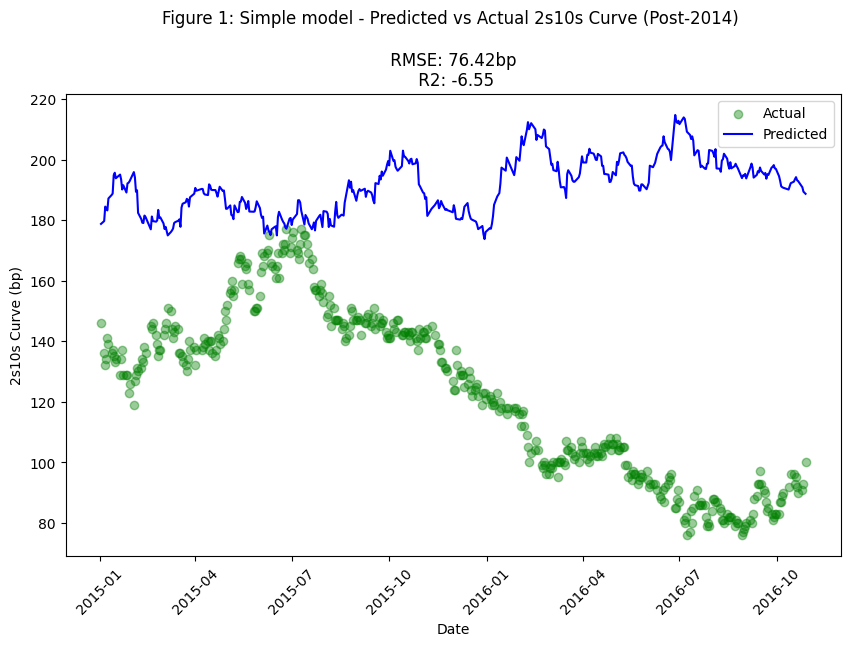

In [316]:
# figure 1 

df_total.dropna(inplace=True)

# Create date mask for test period (after 2014-12-31)
date_mask_train = (df_total['Date'] >= '2006-01-01') & (df_total['Date'] <= '2014-12-31')
date_mask_test = (df_total['Date'] > '2014-12-31')


# Prepare the test data for prediction (Post-2014)

X_train = df_total.loc[date_mask_train, ['forward_swap_1y_1y', '5y5y_BE', 'prop']]
y_train = df_total.loc[date_mask_train, 'curve']

X_test = df_total.loc[date_mask_test, ['forward_swap_1y_1y', '5y5y_BE', 'prop']]
y_test = df_total.loc[date_mask_test, 'curve']

dates_test = df_total.loc[date_mask_test, 'Date']

# Handle missing values
y_test = y_test[X_test.index]  # Align target with features
dates_test = dates_test[X_test.index]  # Align dates with features

model = LinearRegression()  # Initialize the model
model.fit(X_train, y_train)  # Train the model on the training data

# Predict using the trained model
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Compute RMSE
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE) on the test set: {mse}")
print(f"Root Mean Squared Error (RMSE) on the test set: {rmse}")
print(f"R-squared (R2) on the test set: {r2}")

# Plot actual vs predicted values with Date as x-axis
plt.figure(figsize=(10, 6))

# Plot the actual values as a line
plt.scatter(dates_test, y_test, alpha=0.4, color='g', label='Actual')

# Scatter plot the predicted values
plt.plot(dates_test, y_pred, alpha=1, color='b', label='Predicted')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('2s10s Curve (bp)')
plt.title('Figure 1: Simple model - Predicted vs Actual 2s10s Curve (Post-2014) \n\n RMSE: 76.42bp \n R2: -6.55')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Save the figure
plt.savefig(f'{figure_path}/figure_1_with_dates.jpg', format='jpeg', bbox_inches='tight')

# Show the plot
plt.show()



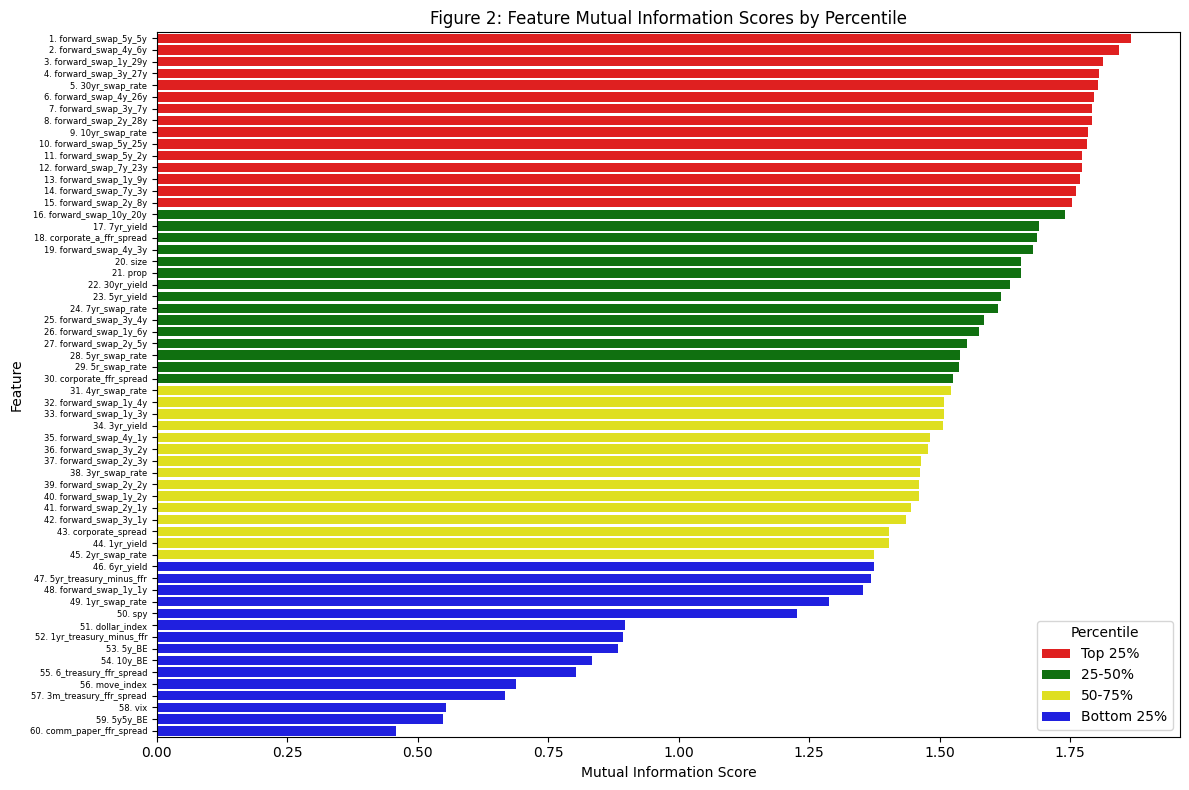


🔹 **Top 25% Features:**
   - forward_swap_5y_5y
   - forward_swap_4y_6y
   - forward_swap_1y_29y
   - forward_swap_3y_27y
   - 30yr_swap_rate
   - forward_swap_4y_26y
   - forward_swap_3y_7y
   - forward_swap_2y_28y
   - 10yr_swap_rate
   - forward_swap_5y_25y
   - forward_swap_5y_2y
   - forward_swap_7y_23y
   - forward_swap_1y_9y
   - forward_swap_7y_3y
   - forward_swap_2y_8y

🔹 **25-50% Features:**
   - forward_swap_10y_20y
   - 7yr_yield
   - corporate_a_ffr_spread
   - forward_swap_4y_3y
   - size
   - prop
   - 30yr_yield
   - 5yr_yield
   - 7yr_swap_rate
   - forward_swap_3y_4y
   - forward_swap_1y_6y
   - forward_swap_2y_5y
   - 5yr_swap_rate
   - 5r_swap_rate
   - corporate_ffr_spread

🔹 **50-75% Features:**
   - 4yr_swap_rate
   - forward_swap_1y_4y
   - forward_swap_1y_3y
   - 3yr_yield
   - forward_swap_4y_1y
   - forward_swap_3y_2y
   - forward_swap_2y_3y
   - 3yr_swap_rate
   - forward_swap_2y_2y
   - forward_swap_1y_2y
   - forward_swap_2y_1y
   - forward_swap_3y_1y
  

In [314]:

# figure 2 


exclude_columns = ['Date', 'curve', '2yr_yield', '10yr_yield']

features = [col for col in df_total.columns if col not in exclude_columns]


# Prepare the data for mutual information calculation
mutual_info_features = df_total.loc[date_mask_train, features]
mutual_info_target = df_total.loc[date_mask_train, 'curve']  # Target variable


# Calculate mutual information between features and target (curve)
mi_scores = mutual_info_regression(mutual_info_features, mutual_info_target)

# Create a DataFrame with features and their corresponding mutual information scores
mi_df = pd.DataFrame({'Feature': mutual_info_features.columns, 'MI_Score': mi_scores})

# Define percentiles
percentile_25 = np.percentile(mi_df['MI_Score'], 25)
percentile_50 = np.percentile(mi_df['MI_Score'], 50)
percentile_75 = np.percentile(mi_df['MI_Score'], 75)

# Assign colors and labels based on percentile bucket
def assign_color_label(score):
    if score >= percentile_75:
        return 'red', 'Top 25%'
    elif score >= percentile_50:
        return 'green', '25-50%'
    elif score >= percentile_25:
        return 'yellow', '50-75%'
    else:
        return 'blue', 'Bottom 25%'

# Apply function to dataframe
mi_df['Color'], mi_df['Percentile'] = zip(*mi_df['MI_Score'].map(assign_color_label))

# Sort features by MI score for better visualization
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

mi_df['Feature1'] = [f"{i+1}. {feat}" for i, feat in enumerate(mi_df['Feature'])]


# Create a color palette mapping
palette = {'Top 25%': 'red', '25-50%': 'green', '50-75%': 'yellow', 'Bottom 25%': 'blue'}

# Plot the data using Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=mi_df['MI_Score'], 
    y=mi_df['Feature1'], 
    hue=mi_df['Percentile'], 
    dodge=False, 
    palette=palette
)

# Improve Y-axis readability by spacing labels
ax.set_yticks(np.arange(len(mi_df['Feature1'])))
ax.set_yticklabels(mi_df['Feature1'], fontsize=6)  # Adjust font size for spacing

plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Figure 2: Feature Mutual Information Scores by Percentile')
plt.legend(title='Percentile', loc='lower right')
plt.tight_layout()
plt.savefig(f'{figure_path}/figure_2.jpg', format='jpeg', bbox_inches='tight')
plt.show()

# Print features in each percentile bucket with better spacing
for percentile in ['Top 25%', '25-50%', '50-75%', 'Bottom 25%']:
    features = mi_df[mi_df['Percentile'] == percentile]['Feature'].tolist()
    print(f"\n🔹 **{percentile} Features:**")
    for feature in features:
        print(f"   - {feature}")





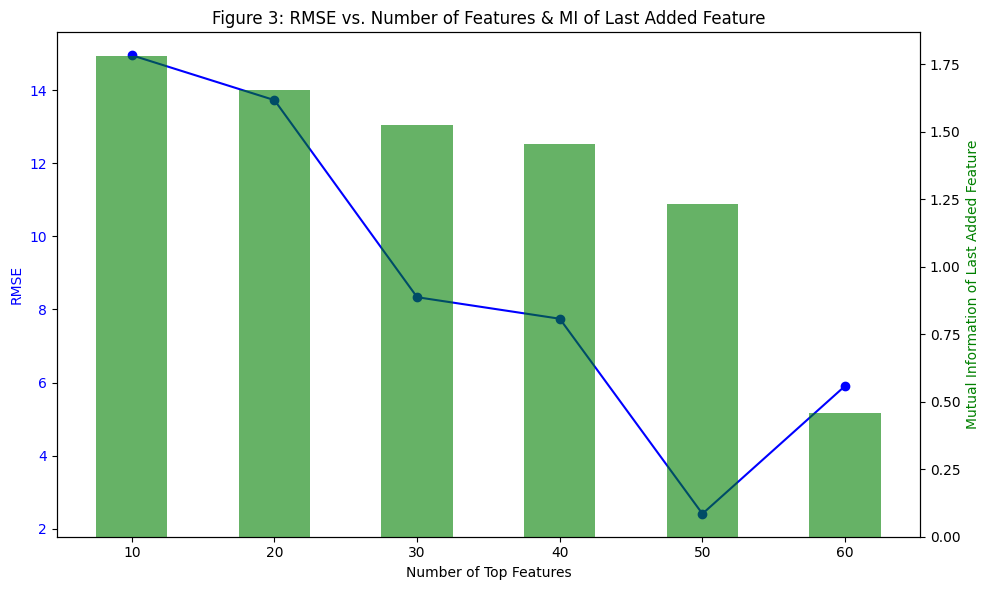

In [304]:
# figure 3

def evaluate_model_with_top_features(top_n_features):
    top_features = mi_df.head(top_n_features)['Feature'].values

    # Prepare the training and testing data using the selected features
    X_train = df_total.loc[date_mask_train, top_features]
    y_train = df_total.loc[date_mask_train, 'curve']
    X_test = df_total.loc[date_mask_test, top_features]
    y_test = df_total.loc[date_mask_test, 'curve']

    # Handle missing values (if any)
    X_train = X_train.dropna(axis=0)
    y_train = y_train[X_train.index]  # Align target with features
    X_test = X_test.dropna(axis=0)
    y_test = y_test[X_test.index]  # Align target with features

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5  # Compute RMSE    


    # Get the mutual information score of the last added feature
    last_feature_mi = mi_df.iloc[top_n_features - 1]['MI_Score']

    return rmse, last_feature_mi  # Return RMSE and mutual information of last added feature

# Tuning the number of top features (10, 20, 30, etc.)
feature_counts = [10, 20, 30, 40, 50, 60]
results_rmse = []
results_mi_last_feature = []

for top_n in feature_counts:
    rmse, mi_last = evaluate_model_with_top_features(top_n)
    results_rmse.append(rmse)
    results_mi_last_feature.append(mi_last)

# Plot RMSE vs. number of top features with mutual information of last added feature
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot RMSE
ax1.plot(feature_counts, results_rmse, marker='o', linestyle='-', color='b', label='RMSE')
ax1.set_xlabel('Number of Top Features')
ax1.set_ylabel('RMSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for the mutual information of the last added feature
ax2 = ax1.twinx()
ax2.bar(feature_counts, results_mi_last_feature, color='green', alpha=0.6, label='Mutual Information of Last Added Feature', width=5)
ax2.set_ylabel('Mutual Information of Last Added Feature', color='g')
ax2.tick_params(axis='y', labelcolor='black')

# Title and layout adjustments
plt.title('Figure 3: RMSE vs. Number of Features & MI of Last Added Feature')
plt.savefig(f'{figure_path}/figure_3.jpg', format='jpeg', bbox_inches='tight')
fig.tight_layout()

# Show the plot
plt.show()


2.410318062635754
0.9924895659615264


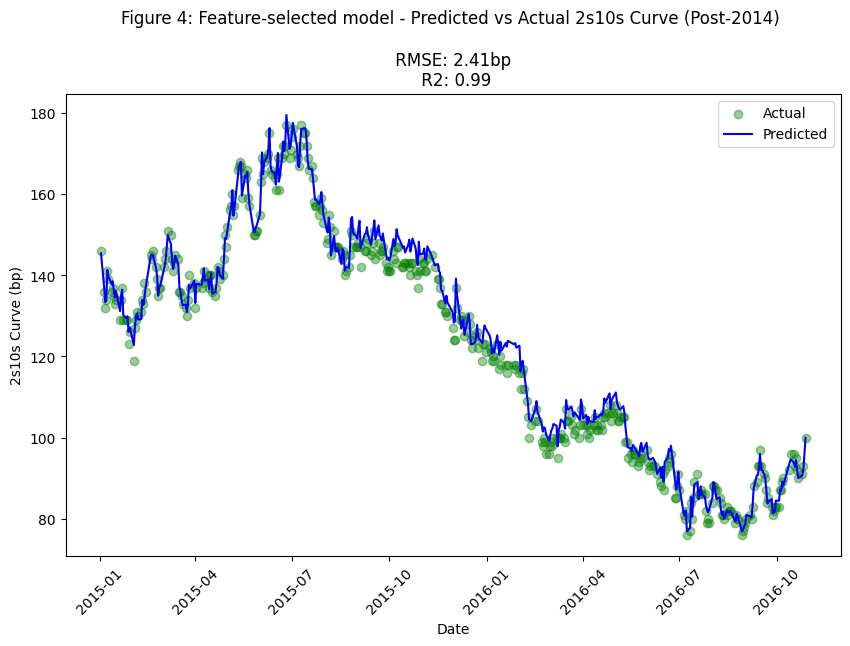

In [296]:
# figure 4

top_features = mi_df.head(50)['Feature'].values

# Prepare the training and testing data using the selected features
X_train = df_total.loc[date_mask_train, top_features]
y_train = df_total.loc[date_mask_train, 'curve']
X_test = df_total.loc[date_mask_test, top_features]
y_test = df_total.loc[date_mask_test, 'curve']

# Handle missing values (if any)
X_train = X_train.dropna(axis=0)
y_train = y_train[X_train.index]  # Align target with features
X_test = X_test.dropna(axis=0)
y_test = y_test[X_test.index]  # Align target with features

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Compute RMSE
r2 = r2_score(y_test, y_pred)

print(rmse)
print(r2)

# Ensure we have the correct Date values for the test set
dates_test = df_total.loc[date_mask_test, 'Date'].loc[X_test.index]

# Plot actual vs. predicted values with Date as x-axis
plt.figure(figsize=(10, 6))

# Plot the actual values as a line
plt.scatter(dates_test, y_test, alpha=0.4, color='g', label='Actual')

# Scatter plot the predicted values
plt.plot(dates_test, y_pred, alpha=1, color='b', label='Predicted')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('2s10s Curve (bp)')
plt.title('Figure 4: Feature-selected model - Predicted vs Actual 2s10s Curve (Post-2014) \n\n RMSE: 2.41bp \n R2: 0.99')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Save the figure
plt.savefig(f'{figure_path}/figure_4.jpg', format='jpeg', bbox_inches='tight')

# Show the plot
plt.show()





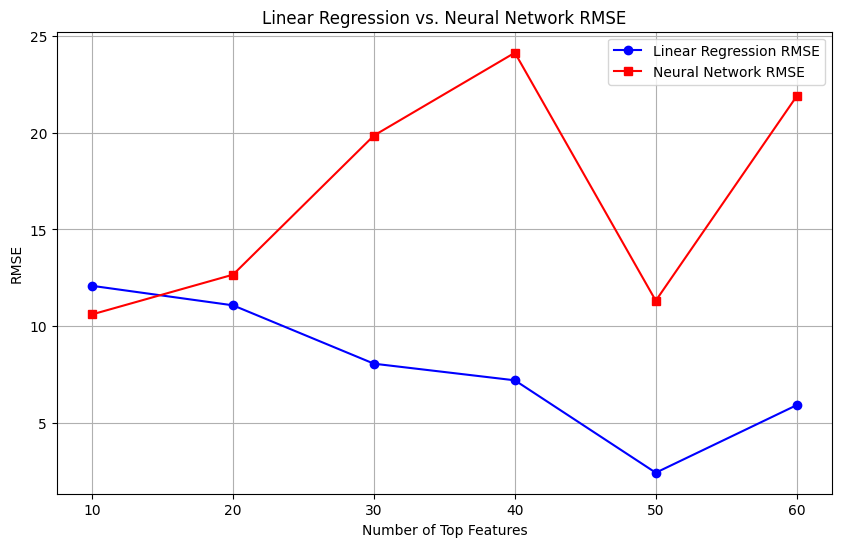

In [232]:
#figure 5

# Define the training and testing periods
date_mask_train = (df_total['Date'] >= '2006-01-01') & (df_total['Date'] <= '2014-12-31')
date_mask_test = (df_total['Date'] > '2014-12-31')

# Create the curve variable (10yr - 2yr yield difference)
df_total['curve'] = (df_total['10yr_yield'] - df_total['2yr_yield'])*100

# Exclude columns that should not be used in the feature set
exclude_columns = ['Date', 'curve', '2yr_yield', '10yr_yield']
features = [col for col in df_total.columns if col not in exclude_columns]

# Prepare the data for mutual information calculation
X_all = df_total.loc[:, features]  # All feature columns
y_all = df_total['curve']  # Target variable

# Calculate mutual information between features and target (curve)
mi_scores = mutual_info_regression(X_all, y_all)

# Create a DataFrame with features and their corresponding mutual information scores
mi_df = pd.DataFrame({'Feature': X_all.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)  # Sort in descending order


# Function to evaluate models (Linear Regression and Neural Network)
def evaluate_models(top_n_features):
    top_features = mi_df.head(top_n_features)['Feature'].values

    # Prepare the training and testing data using the top N features
    X_train = df_total.loc[date_mask_train, top_features]
    y_train = df_total.loc[date_mask_train, 'curve']
    X_test = df_total.loc[date_mask_test, top_features]
    y_test = df_total.loc[date_mask_test, 'curve']

    # Handle missing values (if any)
    X_train = X_train.dropna(axis=0)
    y_train = y_train[X_train.index]  # Align target with features
    X_test = X_test.dropna(axis=0)
    y_test = y_test[X_test.index]  # Align target with features

    # Standardize features (important for neural networks)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ---- Train Linear Regression ----
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    y_pred_lin = lin_model.predict(X_test)
    mse_lin = mean_squared_error(y_test, y_pred_lin)  # MSE
    rmse_lin = mse_lin ** 0.5  # RMSE

    # ---- Train Neural Network (MLP) with Best Parameters ----
    nn_model = MLPRegressor(
        hidden_layer_sizes=(100, 50), 
        activation='tanh', 
        solver='adam', 
        max_iter=1000, 
        random_state=42,
        alpha=0.01, 
        learning_rate='constant', 
        learning_rate_init=0.01
    )
    nn_model.fit(X_train_scaled, y_train)
    y_pred_nn = nn_model.predict(X_test_scaled)
    mse_nn = mean_squared_error(y_test, y_pred_nn)  # MSE
    rmse_nn = mse_nn ** 0.5  # RMSE

    # Return RMSE for both models
    return rmse_lin, rmse_nn


# Try different numbers of features
feature_counts = [10, 20, 30, 40, 50, 60]
results_rmse_lin = []
results_rmse_nn = []

for top_n in feature_counts:
    rmse_lin, rmse_nn = evaluate_models(top_n)
    results_rmse_lin.append(rmse_lin)
    results_rmse_nn.append(rmse_nn)

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, results_rmse_lin, marker='o', linestyle='-', color='b', label='Linear Regression RMSE')
plt.plot(feature_counts, results_rmse_nn, marker='s', linestyle='-', color='r', label='Neural Network RMSE')
plt.xlabel('Number of Top Features')
plt.ylabel('RMSE')
plt.title('Linear Regression vs. Neural Network RMSE')
plt.legend()
plt.grid(True)
plt.show()



In [233]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Define the MLPRegressor model
mlp_model = MLPRegressor(max_iter=1000, random_state=42)

# Define a grid of parameters to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (200,)],  # Experiment with different layer sizes
    'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimizers
    'learning_rate': ['constant', 'adaptive'],  # Learning rate options
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'learning_rate_init': [0.001, 0.01, 0.1]  # Initial learning rate
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform Grid Search with the top N features
def grid_search_mlp(top_n_features):
    top_features = mi_df.head(top_n_features)['Feature'].values
    X_train = df_total.loc[date_mask_train, top_features]
    y_train = df_total.loc[date_mask_train, 'curve']
    X_test = df_total.loc[date_mask_test, top_features]
    y_test = df_total.loc[date_mask_test, 'curve']

    # Handle missing values (if any)
    X_train = X_train.dropna(axis=0)
    y_train = y_train[X_train.index]  # Align target with features
    X_test = X_test.dropna(axis=0)
    y_test = y_test[X_test.index]  # Align target with features

    # Standardize features (important for neural networks)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit GridSearchCV
    grid_search.fit(X_train_scaled, y_train)

    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Predict using the best model
    y_pred_nn = best_model.predict(X_test_scaled)

    # Calculate RMSE
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    rmse_nn = mse_nn ** 0.5  # RMSE

    return rmse_nn, best_params

# Example for a top_n_feature count (e.g., 20)
rmse, best_params = grid_search_mlp(50)
print(f"Optimized RMSE: {rmse}")
print(f"Best Parameters: {best_params}")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilaye

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Li

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:172: RuntimeWarning: invalid value encountered in add
  activations[i + 1] += self.intercepts_[i]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solv

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return (

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't co

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/ext

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Li

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, lea

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, lear

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   5.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, le

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.1

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   7.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   7.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   7.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   5.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   7.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   7.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   8.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ 

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Li

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:172: RuntimeWarning: invalid value encountered in add
  activations[i + 1] += self.intercepts_[i]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Li

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:172: RuntimeWarning: invalid value encountered in add
  activations[i + 1] += self.intercepts_[i]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Li

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Li

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   4.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   4.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   4.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   2.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_ra

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   6.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the opt

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   6.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   7.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   7.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   7.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   7.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   8.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solve

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   6.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   6.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   7.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   7.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   7.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   6.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   6.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   7.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   8.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Li

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:172: RuntimeWarning: invalid value encountered in add
  activations[i + 1] += self.intercepts_[i]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/sit

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: Run

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Li

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; t

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_ne

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Li

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; tot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return (

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Framewor

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Li

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_s

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   7.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   7.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encoun

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   8.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   7.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   8.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   8.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   7.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   7.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   8.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   8.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   8.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   8.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   7.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   6.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   8.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   8.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.1

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   8.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   8.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; t

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   6.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   5.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solv

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01,

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=a

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; t

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   7.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   8.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   8.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   7.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, so

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, lea

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   8.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, l

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framew

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=  10.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached a

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   8.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   8.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; to

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=ad

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; tot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   2.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   5.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   4.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  11.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning:

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached a

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   9.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=  10.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached a

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; to

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total t

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total tim

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time= 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam;

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   5.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; t

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=a

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; tota

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_ini

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   8.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framew

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sg

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_base.py:127: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, lear

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   5.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, lea

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=const

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   5.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   5.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, le

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptiv

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), le

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   1.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  10.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  11.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   7.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   2.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   6.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, l

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  11.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   2.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   8.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   8.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  11.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   7.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   8.8s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   8.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  11.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_r

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, lea

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   5.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   5.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, learning_r

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learnin

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learnin

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), lear

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   9.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), lear

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  10.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  10.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  10.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   7.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, lear

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   8.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   2.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   7.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   7.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   9.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   8.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  11.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   2.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_r

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   9.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   4.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   3.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   2.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_ini

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   6.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   6.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_in

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   5.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   6.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=   9.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=c

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  10.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   2.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   3.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  11.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rat

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=  10.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  11.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=adam; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=  11.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   7.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   9.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_r

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=adam; total time=   1.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   6.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=constant, learning_rate_i

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=adam; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   6.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   7.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   8.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  10.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=  10.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.8s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=adam; total time=   1.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_i

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   8.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
267 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
267 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimato

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(200,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   8.7s
Optimized RMSE: 6.592329422185986
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [234]:
print(f"Optimized RMSE: {rmse}")
print(f"Best Parameters: {best_params}")

Optimized RMSE: 6.592329422185986
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}
